#DATASCI W261: Machine Learning at Scale

**Nick Hamlin** (nickhamlin@gmail.com)  
**Tigi Thomas** (tgthomas@berkeley.edu)  
**Rock Baek** (rockb1017@gmail.com)  
**Hussein Danish** (husseindanish@gmail.com)  
  
Time of Submission: 9:23 PM EST, Wednesday, Feb 24, 2016  
W261-3, Spring 2016  
Week 6 Homework

###Submission Notes:
- For each problem, we've included a summary of the question as posed in the instructions.  In many cases, we have not included the full text to keep the final submission as uncluttered as possible.  For reference, we've included a link to the original instructions in the "Useful Reference" below.
- Some aspects of this notebook don't always render nicely into PDF form.  In these situations, please reference [the complete rendered notebook on Github](https://github.com/nickhamlin/mids_261_homework/blob/master/HW4/MIDS-W261-2015-HWK-Week06-Hamlin-Thomas-Baek-Danish.ipynb)
- We've found that the Latex equations render beautifully on a local ipython server, but the quality varies depending on which browser one uses when rendering a notebook online.  Chrome isn't perfect, but seems to work the best of the browsers (Firefox renders way to small, IE renders way to big).  For highest quality results, please run the notebook locally.

###Useful References:
- **[Original Assignment Instructions](https://www.dropbox.com/sh/5bex8l871t0bg3a/AABXfLW7xv9OUAzY01fMa29za/HW6-Questions.txt?dl=0)**
- [Linear Regression in MRJob](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/kritdm3mo1daolj/MrJobLinearRegressionGD.ipynb)


In [1]:
#Use this to make sure we reload the MrJob code when we make changes
%load_ext autoreload
%autoreload 2
#Render matplotlib charts in notebook
%matplotlib inline

#Import some modules we know we'll use frequently
import numpy as np
import pylab as plt

## HW 6.0

### HW 6.0 - Problem Statement
In mathematics, computer science, economics, or management science what is mathematical optimization? Give an example of a optimization problem that you have worked with directly or that your organization has worked on. Please describe the objective function and the decision variables. Was the project successful (deployed in the real world)? Describe.

### HW 6.0 - Response
Mathematical optimization is the selection of a best element (with regard to some criteria) from some set of available alternatives. In the simplest case, an optimization problem consists of maximizing or minimizing a real function by systematically choosing input values from within an allowed set and computing the value of the function.

*Optimization for inventory warehousing*

A common supply chain problem revolves around minimizing the cost of inventory that is staying in a warehouse. In this situation, a company will have a number of different products that each take up different amounts of space in the warehouse. The goal will be to find a combination of product quantities such that the space is best utilized. For example, let us consider a simplified scenario where our warehouse contains 100 different locations. Let us further say that we only carry two different products and that their quantities are denoted x1 and x2. Product 1 takes up two locations whereas product 2 takes up three locations. In this situation, our objective function is equal to 2x1 + 3x2 and this function is constrained to be less than or equal to 100. The decision variables here are the product quantities x1 and x2.

Many such projects have been deployed in the real word, however in reality there are often more variables and constraints to take into account such as the cost of the product, how often it is received, how often it is ordered, etc... In addition, inventory might be seasonal and can change and the frequency with which it is handled can change every few months. However, we have worked on many implementations with variations of this setup and they have had varying degress of success depending on the situation at the client.


##HW6.1 

### HW 6.1 Problem Statement
Optimization theory: 
For unconstrained univariate optimization what are the first order necessary Conditions for Optimality (FOC).  What are the second order optimality conditions (SOC)? Give a mathematical defintion. 

Also in python, plot the univartiate function X^3 -12x^2-6 defined over the real  domain -6 to +6. Also plot its corresponding first and second derivative functions. Eyeballing these graphs, identify candidate optimal points and then classify them as local minimums or maximums. Highlight and label these points in your graphs. Justify your responses using the FOC and SOC.

For unconstrained multi-variate optimization what are the first order  Necessary Conditions for Optimality (FOC).  What are the second order optimality conditions (SOC)? Give a mathematical defintion. What is the Hessian matrix in this context?

###HW 6.1 Univariate optimiality conditions

For an unconstrained univariate optimization, we have the first-order condition that the first derivative of the objective function will be equal to zero for values of x that represent a maximum or minimum of the objective function.  That is:

$$
f'(x=x*)=0 \tag{First-order condition}
$$

When we find a root based on this first-order condition, we can invoke the second-order conditions for optimality to determine whether or not the root that we've found represents a local maximum or local minimum.  If the second derivative of the objective function is negative, then we've found a local max, and if the second derivative is positive, then we've found a local min.  Mathematically speaking:

$$
\text{if } f"(x=x*)<0, \text{ then maximum} \tag{Second-order conditions}
$$
$$
\text{if } f"(x=x*)>0, \text{ then minimum}
$$

We can see these conditions more clearly in action with the visual example below.
###HW 6.1 Visual Example
To demonstrate, we'll plot the function $f(x)=x^3-12x-6$ along with its first and second derivatives on the same set of axes.

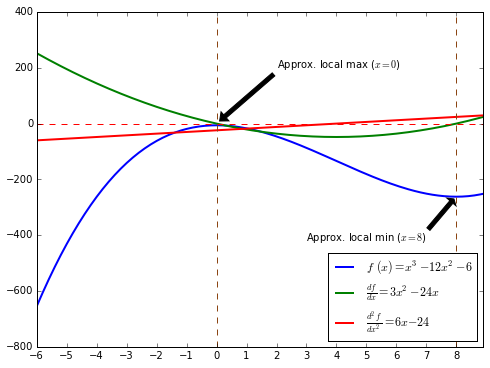

In [10]:
# HW 6.1 - Plotting a visual example
def f(x):
    """The function in question"""
    return x**3-12*x**2-6

def dev1f(x):
    """The first derivative of our function"""
    return 3*x**2-24*x

def dev2f(x):
    """The second derivative of our function"""
    return 6*x-24

def plot_6_1():
    
    #Create vectors for X, Y, Y', and Y"
    x=np.arange(-6,9,.1)
    y0=f(x)
    y1=dev1f(x)
    y2=dev2f(x)

    #Plot each vector on the same coordinate plane
    fg = plt.figure(figsize=(8,6))
    plt.xticks(np.arange(min(x), max(x)+1, 1.0))
    plt.plot(x,y0, color="blue", label='$f\,(x)=x^3-12x^2-6$', linewidth = 2.0)
    plt.plot(x,y1, color="green", label='$\\frac{df}{dx} = 3x^2-24x$', linewidth = 2.0)
    plt.plot(x,y2, color="red", label='$\\frac{d^2f}{dx^2} = 6x-24$', linewidth = 2.0)
    plt.legend(loc='lower right')
    
    #Plot dotted lines at each root and where x=0
    plt.axhline(0, color ="red", ls = '--', )
    plt.axvline(0, color ="saddlebrown", ls = '--')
    plt.axvline(8, color = "saddlebrown", ls = '--')
    
    #Add arrow annotations of critical points
    plt.annotate('Approx. local max ($x=0$)', xy=(0, 0), xytext=(2, 200),
                arrowprops=dict(facecolor='black', shrink=0.05),
                )
    plt.annotate('Approx. local min ($x=8$)', xy=(7.97, -264), xytext=(3, -420),
        arrowprops=dict(facecolor='black', shrink=0.05),
        )
    
    #Display results
    plt.show()
    
plot_6_1()

Here, we can invoke the first-order condition and look for spots where the first derivative (shown in green) crosses the x-axis (shown in red dashes).  These two roots (0 and 8) represent the locations of the local extrema of the objective function (shown in blue).  Based on the second-order conditions, we know that 0 represents a local maximum because the second derivative (shown in red) is negative, while 8 represents a local minimum because the second derivative is positive.

###HW 6.1 Multivariate optimiality conditions
In the multivariate case, we have similar first and second-order conditions for optimality, but we must express them in many dimensions.  Instead of setting the simple first derivative of a univariate objective function equal to 0 to find its extrema, we set the gradient of the multivariate objective function equal to zero to find extreme points.  This gives us:

$$
\nabla f(X=x')=\bigg[\frac{\partial f}{\partial x_1},\frac{\partial f}{\partial x_2},...,\frac{\partial f}{\partial x_n}\bigg]=(0,0,...0) \tag{Multivariate FOC}
$$

Similarly, we can calculate the Hessian matrix, the matrix of partial second derivatives to evaluate the second order conditions.  If the values in the hessian matrix for a particular variable are positive, then we've found a local minimum in that dimension, and vice versa.

$$
H= \begin{bmatrix}
    \frac{\partial^2 f}{\partial x_1^2} & \frac{\partial^2 f}{\partial x_1x_2} & \dots  & \frac{\partial^2 f}{\partial x_1x_n}  \\
    \frac{\partial^2 f}{\partial x_2x_1}  & \frac{\partial^2 f}{\partial x_2^2} & \dots  & \frac{\partial^2 f}{\partial x_2x_n} \\
    \vdots & \vdots & \ddots & \vdots \\
    \frac{\partial^2 f}{\partial x_nx_1} & \frac{\partial^2 f}{\partial x_nx_2} & \dots  & \frac{\partial^2 f}{\partial x_n^2}
    \end{bmatrix} \tag{Hessian Matrix}
$$

##HW6.2

### HW 6.2 Problem Statement
Taking $x=1$ as the first approximation(xt1) of a root of $X^3 + 2x -4 = 0$, use the Newton-Raphson method to calculate the second approximation (denoted as xt2) of this root. (Hint the solution is xt2=1.2)

In [4]:
from __future__ import division

def f(x):
    """Calculate the value of our function"""
    return x**3+2*x-4

def dev1f(x):
    """Calculate the value of our function's derivative"""
    return 3*x**2+2

def iterate_nr_method(xt1):
    """Calculate a single iteration of the Newton-Raphson method for our function"""
    xt2=xt1-(f(xt1)/dev1f(xt1))
    return xt2

iterate_nr_method(1)


1.2

##HW6.3 

### HW 6.3 Problem Statement
Convex optimization 
What makes an optimization problem convex? What are the first order  Necessary Conditions for Optimality in convex optimization.  What are the second order optimality conditions for convex optimization? Are both necessary to determine the maximum or minimum of candidate optimal solutions?

Fill in the BLANKS here:
Convex minimization, a subfield of optimization, studies the problem of minimizing BLANK functions over BLANK sets. The BLANK property can make optimization in some sense "easier" than the general case - for example, any local minimum must be a global minimum.

### HW 6.3 - What makes an optimization problem convex? 
Our optimization problem is convex if the loss function we have is convex, that is, we can assume that there is a single global solution that minimizes our loss.  A loss function is convex if the tangent lines at any point on the loss function are always below the loss function.

### HW 6.3 - What are the first order necessary conditions for optimality in convex optimization.  
The first-order conditions for convex optimization are similar to those described earlier.  Specifically, we must have a loss function that is differentiable.  We will find the optimal solution when the first derivative of this loss function is equal to zero:

$f'(x)  = 0 (\text{for all} x E R)$.

### HW 6.3 - What are the second order optimality conditions for convex optimization? 
The second order conditions for convex optimization is that our function can be differentiated twice and that the second derivative will be positive when the first derivative is equal to zero.  The fact that this second derivative is positive indicates that we have found a global minimum. To summarize: $f''(x)  >= 0 ( \text{for all} x E R )$

### HW 6.3 - Are both necessary to determine the maximum or minimum of candidate optimal solutions?

If we know that the function is convex, we know that our local extremum will be a minimum and that it will be a global minimum.  Therefore, if we know definitively in advance that our function is convex, invoking the second order condition doesn't tell us anything we don't already know.  However, in practice, this is a useful confirmatory step.


### HW 6.3 - Fill in the BLANKS 
Convex minimization, a subfield of optimization, studies the problem of minimizing **convex functions** over **convex sets**. The **convexity** property can make optimization in some sense "easier" than the general case - for example, any local minimum must be a global minimum.

##HW 6.4

### HW 6.4 - Problem Statement
The learning objective function for weighted ordinary least squares (WOLS) (aka weight linear regression) is defined as follows:

0.5\* sumOverTrainingExample i (weight_i \* (W \* X_i - y_i)^2)

Where training set consists of input variables X ( in vector form) and a target variable y, and W is the vector of coefficients for the linear regression model.

Derive the gradient for this weighted OLS by hand; showing each step and also explaining each step.

### HW 6.4 Derivation

Let us formulate the objective function above as follows:

$$ J(W) = 0.5 * \sum\limits_{i} w_i (WX_i - y_i)^2 \tag{1}$$

To get the gradient, we must perform the partial derivative with respect to W. First, we will apply the square term to simplify the terms for the derivatives:

$$ J(W) = 0.5 * \sum\limits_{i} w_i ((WX_i)^2 + y_i^2 - 2WX_iy_i) \tag{2}$$

This further becomes

$$ J(W) = 0.5 * \sum\limits_{i} w_i (W^2X_i^2 + y_i^2 - 2WX_iy_i) \tag{3}$$

The gradient for this is thus:

$$ \frac{\partial J(W)}{\partial W} = \frac{\partial }{\partial W} (0.5 * \sum\limits_{i} w_i (W^2X_i^2 + y_i^2 - 2WX_iy_i)) \tag{4}$$

Then applying the partial derivative with respect to W, we get:

$$ \frac{\partial J(W)}{\partial W} = 0.5 * \sum\limits_{i} w_i (2WX_i^2 - 2X_iy_i) \tag{5}$$

Bringing out the constant term (2) :

$$ \frac{\partial J(W)}{\partial W} = 0.5 * 2 * \sum\limits_{i} w_i (WX_i^2 - X_iy_i) \tag{6}$$

Finally, factoring out Xi:

$$ \frac{\partial J(W)}{\partial W} =  \sum\limits_{i} w_i X_i (WX_i - y_i) \tag{7}$$

To find the value of W which minimizes J(W), we set the gradient to 0 and get:

$$ 0 =  \sum\limits_{i} w_i X_i (WX_i - y_i) \tag{8}$$

##HW 6.5

### HW 6.5 Problem Statement
Write a MapReduce job in MRJob to do the training at scale of a weighted OLS model using gradient descent.

- Generate one million datapoints just like in [this notebook](http://nbviewer.ipython.org/urls/dl.dropbox.com/s/kritdm3mo1daolj/MrJobLinearRegressionGD.ipynb)
- Weight each example like this: $weight(x)= |(1/x)|$
- Sample 1% of the data in MapReduce and use the sampled dataset to train a (weighted if available in SciKit-Learn) [linear regression model locally using  SciKit-Learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
- Plot the resulting weighted linear regression model versus the original model that you used to generate the data. Comment on your findings.

In [21]:
size = 1000000 #Create 1m random points
x = np.random.uniform(-4, 4, size)
y = x * 1.0 - 4 + np.random.normal(0,0.5,size)
data = zip(y,x) #NOTICE THAT THE Y-VALUE COMES FIRST!
np.savetxt('LinearRegression.csv',data,delimiter = ",")

In [22]:
%%writefile MrJobBatchGDUpdate_LinearRegression.py
from __future__ import division

from mrjob.step import MRStep
from mrjob.job import MRJob

def weight_point(x):
    """Define a simple function to calculate our weight value, given an X value"""
    return abs(1/x)

# This MrJob calculates the gradient of the entire training set      
class MrJobBatchGDUpdate_LinearRegression(MRJob):
    # run before the mapper processes any input
    def read_weightsfile(self):
        # Read weights file
        # NOTE - THIS NOMENCLATURE CAN BE CONFUSING!
        # self.weights represents our estimate of the model parameters
        # NOT the weights that we are adding to each point based on the 
        # weighting approach in the problem statement.
        with open('weights.txt', 'r') as f:
            self.weights = [float(v) for v in f.readline().split(',')]
        # Initialize gradient for this iteration
        self.partial_Gradient = [0]*len(self.weights)
        self.partial_count = 0
    
    # Calculate partial gradient for each example 
    def partial_gradient(self, _, line):
        D = (map(float,line.split(',')))
        # y_hat is the predicted value given current weights
        y_hat = self.weights[0]+self.weights[1]*D[1] #Y_hat=beta_0+beta_1*x
        
        # Update partial gradient vector with gradient from current example
        #NOTE THAT THESE NEXT TWO LINES ARE WHERE WE ADD THE WEIGHTS
        #THAT MAKE THIS A WOLS MODEL
        self.partial_Gradient[0]+=(D[0]-y_hat)*weight_point(D[1]) #Update intercept
        self.partial_Gradient[1]+=(D[0]-y_hat)*D[1]*weight_point(D[1]) #Update slope
        self.partial_count+=1
    
    # Finally emit in-memory partial gradient and partial count
    def partial_gradient_emit(self):
        yield None, (self.partial_Gradient,self.partial_count)
        
    # Accumulate partial gradient from mapper and emit total gradient 
    # Output: key = None, Value = gradient vector
    def gradient_accumulater(self, _, partial_Gradient_Record): 
        total_gradient = [0]*2
        total_count = 0
        for partial_Gradient,partial_count in partial_Gradient_Record:
            total_count = total_count + partial_count
            total_gradient[0] = total_gradient[0] + partial_Gradient[0]
            total_gradient[1] = total_gradient[1] + partial_Gradient[1]
        yield None, [v/total_count for v in total_gradient]
    
    def steps(self):
        return [MRStep(mapper_init=self.read_weightsfile,
                       mapper=self.partial_gradient,
                       mapper_final=self.partial_gradient_emit,
                       reducer=self.gradient_accumulater)] 
    
if __name__ == '__main__':
    MrJobBatchGDUpdate_LinearRegression.run()

Overwriting MrJobBatchGDUpdate_LinearRegression.py


In [1]:
from numpy import random,array
from MrJobBatchGDUpdate_LinearRegression import MrJobBatchGDUpdate_LinearRegression

learning_rate = 0.05
stop_criteria = 0.000005

# Generate random values as inital weights
weights = array([random.uniform(-3,3),random.uniform(-3,3)])
# Write the weights to the files
with open('weights.txt', 'w+') as f:
    f.writelines(','.join(str(j) for j in weights))
    
# create a mrjob instance for batch gradient descent update over all data
mr_job = MrJobBatchGDUpdate_LinearRegression(args=['LinearRegression.csv','--file',
                                                   'weights.txt','--no-strict-protocols'])
# Update centroids iteratively
i = 0
while(1):
    print "iteration ="+str(i)+"  weights =",weights
    # Save weights from previous iteration
    weights_old = weights
    with mr_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            # value is the gradient value
            key,value =  mr_job.parse_output_line(line)
            # Update weights
            weights = weights + learning_rate*array(value)
    i+=1
    # Write the updated weights to file 
    with open('weights.txt', 'w+') as f:
        f.writelines(','.join(str(j) for j in weights))
    # Stop if weights get converged
    if(sum((weights_old-weights)**2)<stop_criteria):
        break
        
print "Final weights\n"
print weights

iteration =0  weights = [ 2.84159495 -1.800999  ]
iteration =1  weights = [ 1.06730747 -1.5214152 ]
iteration =2  weights = [-0.24526872 -1.26965372]
iteration =3  weights = [-1.21628526 -1.04296816]
iteration =4  weights = [-1.93462624 -0.8388774 ]
iteration =5  weights = [-2.46604513 -0.65514151]
iteration =6  weights = [-2.85918416 -0.48973941]
iteration =7  weights = [-3.15002727 -0.34084836]
iteration =8  weights = [-3.36519423 -0.20682511]
iteration =9  weights = [-3.52437751 -0.08618864]
iteration =10  weights = [-3.64214504  0.02239546]
iteration =11  weights = [-3.72927373  0.12012933]
iteration =12  weights = [-3.79373606  0.20809568]
iteration =13  weights = [-3.84142986  0.28726959]
iteration =14  weights = [-3.87671822  0.35852909]
iteration =15  weights = [-3.90282885  0.4226647 ]
iteration =16  weights = [-3.92214958  0.48038818]
iteration =17  weights = [-3.93644688  0.53234027]
iteration =18  weights = [-3.94702757  0.57909777]
iteration =19  weights = [-3.95485844  0.

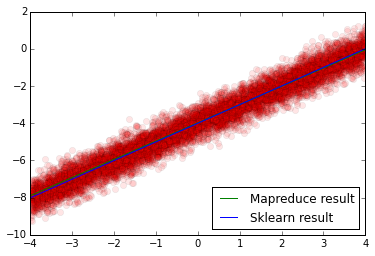

In [12]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import random as rand #avoid namespace collisions

#Randomly sample 1% of our data
n = 1000000 #number of records in file
s = int(n*0.01) #desired sample size
filename = "LinearRegression.csv"
skip = sorted(rand.sample(xrange(n),n-s))
df = pd.read_csv(filename, skiprows=skip, header=None)

#Set up background stuff to plot mapreduce data
floor_x=min(df[1])
ceiling_x=max(df[1])
step_x=(ceiling_x-floor_x)/s
pred_x=np.arange(floor_x,ceiling_x,step_x)

def get_line(x,m,b):
    """Quick function to calculate Y values given X, slope, and intercept"""
    return m*x+b

mr_intercept=weights[0]
mr_slope=weights[1]
pred_y_mr=get_line(pred_x,mr_slope,mr_intercept)

#Build Sklearn model
sklearn_model=LinearRegression()
sklearn_model.fit(df[1].reshape(-1,1),df[0])
sk_slope=sklearn_model.coef_
sk_intercept=sklearn_model.intercept_

pred_y_sk=get_line(pred_x,sk_slope,sk_intercept)

#Actually make the plots
plt.plot(df[1],df[0],'ro',alpha=0.1) #Plot data points, with alpha turned down so we can see the lines
plt.plot(pred_x,pred_y_mr,color="green", label="Mapreduce result") #Plot Mapreduce line
plt.plot(pred_x,pred_y_sk, color="blue", label="Sklearn result") #Plot Sklearn line
plt.legend(loc="lower right")
plt.show()

It's a little difficult to see amid the visual noise of all the individual data points (even after reducing their opacity), but if we look closely we can see that our mapreduce and sklearn results are very similar.  Mapreduce produced a slightly higher intercept and lower slope than the sklearn version of our calculation.


##HW6.6

### HW 6.6 Problem Statement

Improve [this notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/0t7985e40fovlkw/EM-GMM-MapReduce%20Design%201.ipynb) as follows:
- Add in equations into the notebook (not images of equations)
- Number the equations
- Make sure the equation notation matches the code and the code and comments refer to the equations numbers  
- Comment the code  
- Rename/Reorganize the code to make it more readable  
- Rerun the examples with similar graphics (or possibly better graphics)  

NOTE: We had integrated our version of the notebook into this main notebook before the announcement was made that we were allowed to separate them.  We've left it included here, since it also makes it possible to submit the entire assignment in a single document.

##Expectation Step: 
Given priors $\boldsymbol{x}^{(i)}$, mean vector $\boldsymbol{\mu}_k$ and covariance matrix $\boldsymbol{\Sigma}_k$, calculate the probability of that each data point belongs to a class 

$$p(\omega_k|\boldsymbol{x}^{(i)},\theta)=\frac
{\pi_kN(\boldsymbol{x}^{(i)}|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)}
{\sum_{j=1}^{K} [\pi_jN(\boldsymbol{x}^{(i)}|\boldsymbol{\mu}_j,\boldsymbol{\Sigma}_j)]}
\tag{1}$$

##Maximization Step: 
Given probabilities, update priors, mean vector, and covariance matrix

$$\boldsymbol{\hat{\mu}}_k=\frac{1}{n_k}
\sum_{i=1}^{n}
p(\omega_k|\boldsymbol{x}^{(i)},\theta)\boldsymbol{x}^{(i)}
\tag{2}
$$


$$
\boldsymbol{\hat{\Sigma}}_k=\frac{1}{n_k}
\sum_{i=1}^{n}
p(\omega_k|\boldsymbol{x}^{(i)},\theta)
(\boldsymbol{x}^{(i)}-\boldsymbol{\mu}^{(i)})
(\boldsymbol{x}^{(i)}-\boldsymbol{\mu}^{(i)})^T
\tag{3}
$$


$$
\hat{\pi}_k=\frac{n_k}{n}
\mbox{  where  } n_k= \sum_{i=1}^{n}
p(\omega_k|\boldsymbol{x}^{(i)},\theta)
\tag{4}
$$

## Data Generation

In [3]:
import json

#Generate 3 clusters of 1000 points each
size1 = size2 = size3 = 1000

#First cluster is centered at (4,0)
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1

#Second cluster is centered at (6,6)
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)

#Third cluster is centered at (0,4)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)

#Randomize ordering of data and save to file
data = data[np.random.permutation(size1+size2+size3),]
with open("data.txt", "w") as f:
    for row in data.tolist():
        json.dump(row, f)
        f.write("\n")

# Data Visualization
As a starting point, it's useful to be able to see the actual clusters of data we're trying to "discover" below.

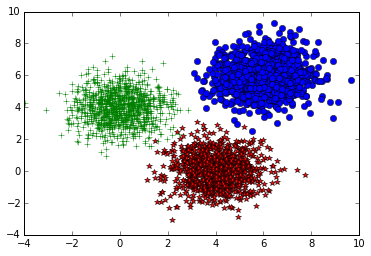

In [4]:
plt.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red')
plt.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue')
plt.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green')
plt.show()

# Initialization
Here suppose we know there are 3 components

In [5]:
%%writefile mr_GMixEmInitialize.py
from __future__ import division
import json
from math import pi, sqrt, exp, pow
from random import sample

from numpy import mat, zeros, shape, random, array, zeros_like, dot, linalg
from mrjob.job import MRJob

class MrGMixEmInit(MRJob):
    DEFAULT_PROTOCOL = 'json'
    
    def __init__(self, *args, **kwargs):
        super(MrGMixEmInit, self).__init__(*args, **kwargs)
        self.numMappers = 1 #We only need one mapper to initialize our starting cluster centroids
        self.count = 0 #Keep track of how many example data points we've ingested
        self.jsonOut= None #Initialize somewhere to store our eventual output
        
                                                 
    def configure_options(self):
        """
        Set up infrastructure to enable us to pass important parameters into the job
        when we call it
        """
        super(MrGMixEmInit, self).configure_options()
        
        #Number of clusters we want (defaults to 3)
        self.add_passthrough_option(
            '--k', dest='k', default=3, type='int',
            help='k: number of densities in mixture')
        
        #Path to wherever we want our output files to be saved
        self.add_passthrough_option(
            '--pathName', dest='pathName', default="", type='str',
            help='pathName: pathname where intermediateResults.txt is stored')
        
    def mapper(self, _, xjIn):
        """
        Extract a random starting 2*K points from our input data and emit to the reducer
        """
        if self.count <= 2*self.options.k:
            self.count += 1
            #Emit records with a static key
            yield (1,xjIn)        
        
    def reducer(self, key, xjIn):  
        """
        Accumulate data points mapped to 0 from 1st mapper and 
        pull out k of them as our starting point
        """
        
        #Randomly choose K starting centroids
        centroid_possibilities=[json.loads(xj) for xj in xjIn] 
        centroids=sample(centroid_possibilities,self.options.k)
        
        #use the covariance of the selected centers as the starting guess for covariances

        #Calculate the mean of our starting centroids
        mean = array(centroids[0])
        for i in range(1,self.options.k):
            mean+=array(centroids[i])
        mean/=self.options.k #This is the starting point for equation 2 above
              
        #Accumulate the deviations
        cov = zeros((len(mean),len(mean)),dtype=float)
        for x in centroids:
            xmm = array(x) - mean
            for i in range(len(mean)):
                cov[i,i]+=xmm[i]*xmm[i]
        
        cov/=self.options.k
        
        #Calculate inverse of covariances - This is equivalent to equation 3 from above
        covInv = linalg.inv(cov)
        cov_1 = [covInv.tolist()]*self.options.k
        
        #It might be useful to examine our intermediate outputs, so we'll write them to 
        #their own file, just in case.
        jDebug = json.dumps([centroids,mean.tolist(),cov.tolist(),covInv.tolist(),cov_1])    
        debugPath = self.options.pathName + '/debug.txt'
        with open(debugPath,'w+') as f:
            f.write(jDebug)
        
        #We also need a starting guess at the phi's - prior probabilities
        #initialize them all with the same number (1/k) to represent equal probabilities for each cluster
        phi = zeros(self.options.k,dtype=float) 
        for i in range(self.options.k):
            phi[i] = 1/self.options.k #These represent the starting values for equation 1 above
        
        
        #Form output object
        outputList = [phi.tolist(), centroids, cov_1]    
        self.jsonOut  = json.dumps(outputList)
               
        #Write new parameters to file
        fullPath = self.options.pathName + '/intermediateResults.txt'            
        with open(fullPath,'w+') as f:
            f.write(self.jsonOut)

if __name__ == '__main__':
    MrGMixEmInit.run()

Overwriting mr_GMixEmInitialize.py


# Iteration
**Mapper** – each mapper needs k vector means and covariance matrices to make probability calculations.  Can also accumulate partial sum (sum restricted to the mapper's input) of quantities required for update.  Then it emits partial sum as single output from combiner.  
    Emit (dummy_key, partial_sum_for_all_k's)
    
**Reducer** –the iterator pulls in the partial sum for all k's from all the mappers and combines in a single reducer.  In this case the reducer emits a single (json'd python object) with the new means and covariances.


In [6]:
%%writefile mr_GMixEmIterate.py
from mrjob.job import MRJob

from math import sqrt, exp, pow,pi
from numpy import zeros, shape, random, array, zeros_like, dot, linalg
import json

def gauss(x, mu, P_1):
    """
    Compute a Gaussian given:
    x: Vector of values
    mu: vector of means
    P_1: Inverted covariance matrix (which we calculate in the reducer)
    """
    xtemp = x - mu
    n = len(x)
    p = exp(- 0.5*dot(xtemp,dot(P_1,xtemp)))
    detP = 1/linalg.det(P_1)
    p = p/(pow(2.0*pi,n/2.0)*sqrt(detP))
    return p

class MrGMixEm(MRJob):
    DEFAULT_PROTOCOL = 'json'
    
    def __init__(self, *args, **kwargs):
        super(MrGMixEm, self).__init__(*args, **kwargs)
        
        #Load previous iteration results from disk
        fullPath = self.options.pathName + '/intermediateResults.txt'
        with open(fullPath,'r') as f:
            inputJson = f.read()   
        inputList = json.loads(inputJson)
        
        #Store previous iteration components in their own variables
        self.phi = array(inputList[0])           #prior class probabilities
        self.means = array(inputList[1])         #current means list
        self.cov_1 = array(inputList[2])         #inverse covariance matrices for w, calc.
        
        #Create destinations for next iteration's results
        self.new_phi = zeros_like(self.phi)        #partial weighted sum of weights
        self.new_means = zeros_like(self.means)
        self.new_cov = zeros_like(self.cov_1)
        
        #Other setup requirements
        self.numMappers = 1             #number of mappers
        self.count = 0                  #passes through mapper
                                                   
                                                 
    def configure_options(self):
        """
        Set up infrastructure to enable us to pass important parameters into the job
        when we call it
        """
        super(MrGMixEm, self).configure_options()
        
        #Number of clusters we want (defaults to 3)
        self.add_passthrough_option(
            '--k', dest='k', default=3, type='int',
            help='k: number of densities in mixture')
        
        #Path to wherever we want our output files to be saved
        self.add_passthrough_option(
            '--pathName', dest='pathName', default="", type='str',
            help='pathName: pathname where intermediateResults.txt is stored')
        
    def mapper(self, key, val):
        """accumulate partial sums for each mapper"""
        x = array(json.loads(val)) #Load each record
        
        #Calculate probabilty of each point being from each
        #centroid (that is, estimate class assignments)
        #based on the mean vector and covariance matrix
        #This is the execution of the expecation step shown in Equation 1 above.
        wtVect = zeros_like(self.phi) #This is an array of priors
        for i in range(self.options.k):
            wtVect[i] = self.phi[i]*gauss(x,self.means[i],self.cov_1[i])

        #Normalize elements of probability vector
        wtVect/=sum(wtVect)
                    
        #Accumulate to update our est of probability densities.
        self.count += 1 #increment count
        #Accumulate weights for new prior estimates
        #These are partial sums that will be completed in the reducer
        self.new_phi+=wtVect
        for i in range(self.options.k):
            #Accumulate weighted x's for new mean calculation
            self.new_means[i]+=wtVect[i]*x
            #Accumulate weighted squares for new covariance estimate
            xmm = x - self.means[i]
            covInc = zeros_like(self.new_cov[i])
            for l in range(len(xmm)):
                for m in range(len(xmm)):
                    covInc[l][m] = xmm[l]*xmm[m]
            self.new_cov[i] = self.new_cov[i] + wtVect[i]*covInc
        #We don't yield anything here, since we do that via mapper_final

    def mapper_final(self):
        """
        Aggregate mapper results 
        (running totals for priors, centroids, and covariance matrix)
        into a list of lists and emit to the reducer
        """
        out = [self.count, (self.new_phi).tolist(), (self.new_means).tolist(), (self.new_cov).tolist()]
        jOut = json.dumps(out)        
        yield 1,jOut
    
    
    def reducer(self, key, xs):
        #Accumulate partial sums emitted by the mapper
        first = True        
        #xs gives us a list of partial stats, including counts, posteriors, means, and covariance. 
        
        #Each stat is an array that stores information for K components
        for val in xs:
            temp = json.loads(val)
            if first:  #For the first record that arrives, initialize the destination arrays
                totCount = temp[0]
                totPhi = array(temp[1])
                totMeans = array(temp[2])
                totCov = array(temp[3])                
                first = False
            else: 
                #For each subsequent record that arrives, update the cumulative sum of the four arrays
                totCount+=temp[0]
                totPhi+=array(temp[1])
                totMeans+=array(temp[2])
                totCov+=array(temp[3])
                
        #Finish calculation of new probability parameters. array divided by array
        newPhi = totPhi/totCount
        #Initialize these to something we already know to make sure we have the right size arrays
        newMeans = totMeans
        newCov_1 = totCov
        
        #For each centroid, calculate new mean and covariance
        #This is the Maximization step shown in Equations 2-4 above.
        for i in range(self.options.k):
            newMeans[i,:] = totMeans[i,:]/totPhi[i]
            tempCov = totCov[i,:,:]/totPhi[i]
            #Invert the covariance matrix here to avoid doing a matrix inversion
            #with every input data point.
            newCov_1[i,:,:] = linalg.inv(tempCov)
        
        #Compile our new parameters together and write to file
        #This enables us to pass them to the next iteration of the algorithm
        outputList = [newPhi.tolist(), newMeans.tolist(), newCov_1.tolist()]
        jsonOut = json.dumps(outputList)
        fullPath = self.options.pathName + '/intermediateResults.txt'
        with open(fullPath,'w') as f:
            f.write(jsonOut)


if __name__ == '__main__':
    MrGMixEm.run()

Overwriting mr_GMixEmIterate.py


# Driver

Iteration 0
Mean 0: [-0.7711333296788728, 3.2043728958077144]
Mean 1: [0.13937949139759165, 3.654284598341057]
Mean 2: [6.370756548444613, 5.464212291594231]


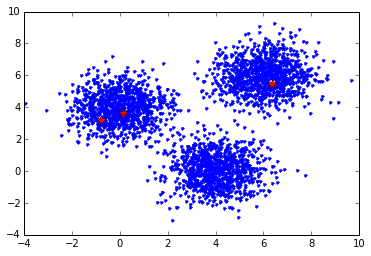

-----------------------------------------
Iteration 1
Mean 0: [2.619456018975777, 1.2744735629827668]
Mean 1: [1.5592318996128811, 2.958110015973727]
Mean 2: [5.534291741740489, 6.011937587836843]


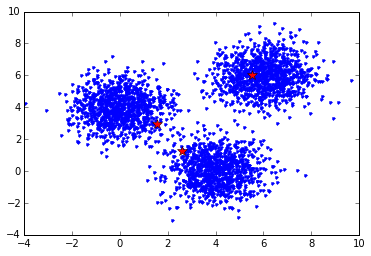

-----------------------------------------
Iteration 2
Mean 0: [2.4541387333869986, 1.3295147163115784]
Mean 1: [1.4999969637065689, 2.83395890512229]
Mean 2: [5.816810298462987, 5.9871964156114]


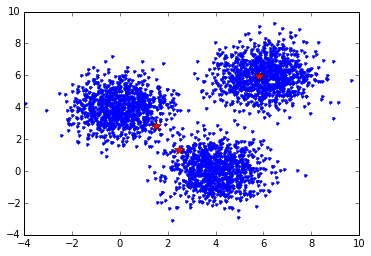

-----------------------------------------
Iteration 3
Mean 0: [2.462315648288502, 1.3371557553347866]
Mean 1: [1.4112289422246447, 2.9212163026001923]
Mean 2: [5.9864110124348215, 6.002756265358446]


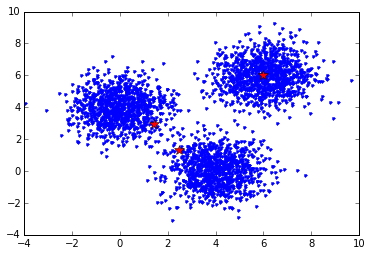

-----------------------------------------
Iteration 4
Mean 0: [2.490890089304566, 1.3177666880325873]
Mean 1: [1.3730000143569125, 2.9723595848903233]
Mean 2: [6.022436564726606, 6.009811127756954]


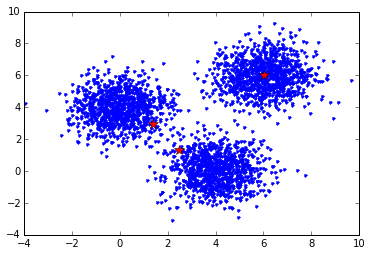

-----------------------------------------
Iteration 5
Mean 0: [2.52624478278237, 1.2879226219316864]
Mean 1: [1.3275702054624268, 3.016125824855229]
Mean 2: [6.026050032925606, 6.0114333343205315]


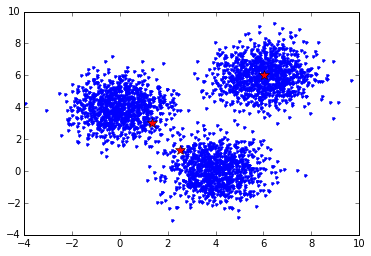

-----------------------------------------
Iteration 6
Mean 0: [2.5675651767451786, 1.2518507211309695]
Mean 1: [1.2717849626397248, 3.065849441463527]
Mean 2: [6.026319141798526, 6.011677282551615]


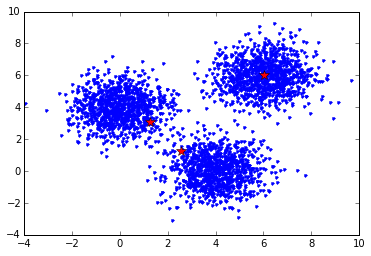

-----------------------------------------
Iteration 7
Mean 0: [2.616800672309223, 1.2089102959303695]
Mean 1: [1.2045340010289627, 3.125093445705102]
Mean 2: [6.026274223659897, 6.011673933393124]


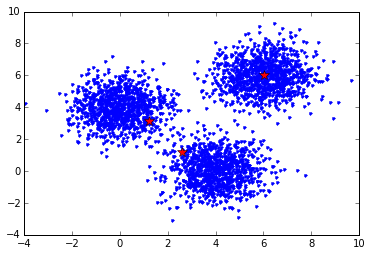

-----------------------------------------
Iteration 8
Mean 0: [2.676646856505984, 1.1571698379841953]
Mean 1: [1.1223480915202284, 3.196937499453667]
Mean 2: [6.026225065313993, 6.011646634150189]


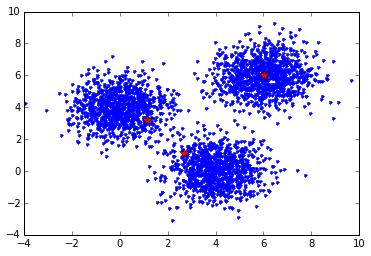

-----------------------------------------
Iteration 9
Mean 0: [2.7510277292399485, 1.093644258034124]
Mean 1: [1.019711624185032, 3.285687129608099]
Mean 2: [6.026203394075558, 6.011623012152344]


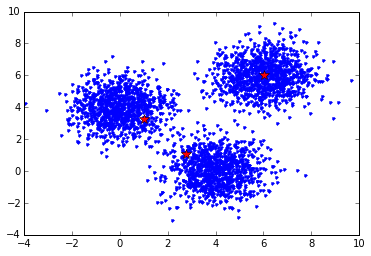

-----------------------------------------
Iteration 10
Mean 0: [2.84582800178391, 1.0139203468726616]
Mean 1: [0.888417449332348, 3.3974808855771474]
Mean 2: [6.026209713073793, 6.011596269511067]


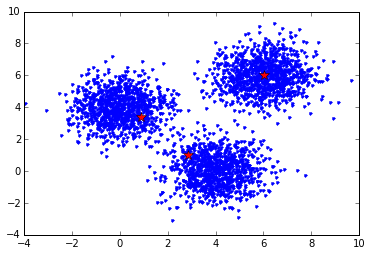

-----------------------------------------
Iteration 11
Mean 0: [2.9698440963423596, 0.9116212922775473]
Mean 1: [0.7169472826111314, 3.540289420085548]
Mean 2: [6.026238810114926, 6.011543690346106]


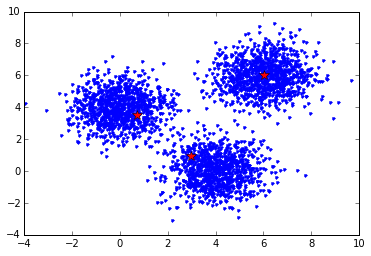

-----------------------------------------
Iteration 12
Mean 0: [3.1352282246626997, 0.7783586664188549]
Mean 1: [0.4933741298634283, 3.7202105830060255]
Mean 2: [6.026271194970941, 6.011409148208319]


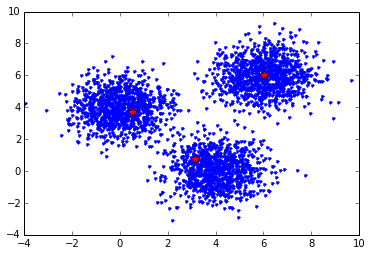

-----------------------------------------
Iteration 13
Mean 0: [3.353252954247632, 0.6066556175352659]
Mean 1: [0.22758087160672694, 3.921033360134669]
Mean 2: [6.0262203369262695, 6.011053797357594]


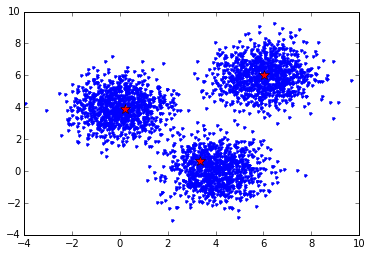

-----------------------------------------
Iteration 14
Mean 0: [3.612628450761543, 0.4022068741760169]
Mean 1: [0.015771755732829865, 4.0560011426299685]
Mean 2: [6.025729351492224, 6.010282826960138]


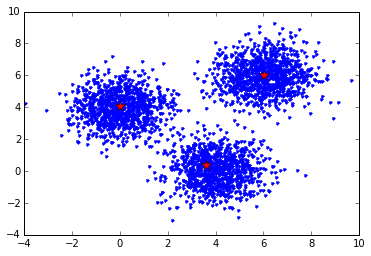

-----------------------------------------
Iteration 15
Mean 0: [3.833672438494614, 0.222339019302665]
Mean 1: [-0.043729303072058696, 4.063013832488475]
Mean 2: [6.024083414472153, 6.0093409094693335]


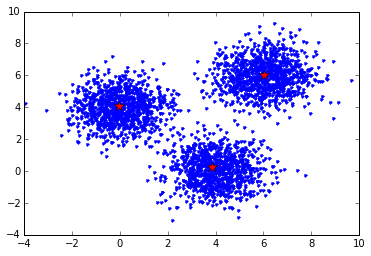

-----------------------------------------
Iteration 16
Mean 0: [3.9522171255617318, 0.12108899345039922]
Mean 1: [-0.028747140584364398, 4.028925891255205]
Mean 2: [6.022453998308786, 6.008723900997814]


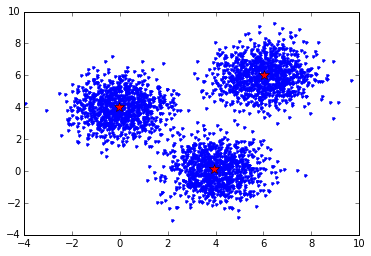

-----------------------------------------
Iteration 17
Mean 0: [3.9963903892582526, 0.07907379616371635]
Mean 1: [-0.007570809270497964, 4.00558369432295]
Mean 2: [6.02159479500414, 6.0081415990626805]


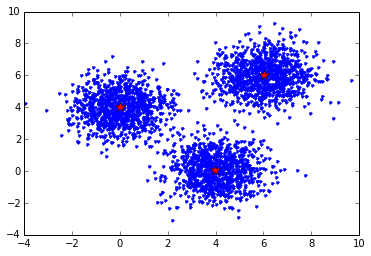

-----------------------------------------
Iteration 18
Mean 0: [4.008430365506228, 0.06651902914198779]
Mean 1: [0.001987220347110722, 3.996420891276414]
Mean 2: [6.0213137299158435, 6.007722204449387]


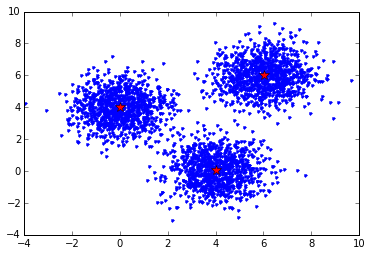

-----------------------------------------
Iteration 19: MODEL HAS CONVERGED!
Mean 0: [4.011594675835418, 0.06295618108924489]
Mean 1: [0.005221290969785533, 3.993564222512047]
Mean 2: [6.021269380986998, 6.007572290276761]


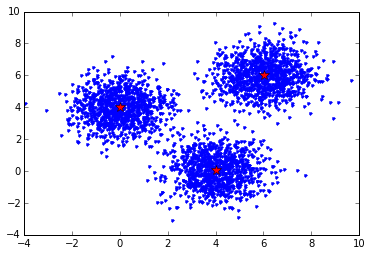

In [9]:
from mr_GMixEmInitialize import MrGMixEmInit
from mr_GMixEmIterate import MrGMixEm
import json
import os
from math import sqrt

#Load original data points for plotting 
filePath = 'data.txt'
original_data=[]
with open(filePath,'r') as input_data:
    for i in input_data.readlines():
        original_data.append(eval(i.strip()))
original_data=np.array(original_data)    

def plot_iteration(means):
    """Plot both our original data points, as well as the current location of our centroids"""
    plt.plot(original_data[:, 0], original_data[:, 1],'.', color = 'blue')
    plt.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    plt.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    plt.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    plt.show()

def dist(x,y):
    """Calculate the euclidean distance between two lists"""   
    sum = 0.0
    for i in range(len(x)):
        temp = x[i] - y[i]
        sum += temp * temp
    return sqrt(sum)


#INITIALIZE STARTING CENTROIDS

#If you don't pass the current dir as the --pathName, all the files will get stuck in the MrJob
#temp folder and not be accessible to the driver function, and everything will fail for
#no apparent reason.
pwd=os.getcwd()
mrJob = MrGMixEmInit(args=[filePath,'--no-strict-protocols','--pathName',pwd])
with mrJob.make_runner() as runner:
    runner.run()

#pull out the centroid values to compare with values after one iteration
emPath = "intermediateResults.txt"
with open(emPath) as fileIn:
    paramJson = fileIn.read()

#Initialize the "previous step delta" to something really high to start out
#this will get updated with every iteration of the algorithm, which we'll consider
#to have converged once delta falls below a certain threshold.
delta = 10
iter_num = 0 #Which iteration are we on?

#BEGIN ITERATIONS
while delta > 0.02:
    print "Iteration " + str(iter_num)
    iter_num = iter_num + 1
    #Parse old centroid values from file
    oldMeans = json.loads(paramJson)[1]
    
    #Run one iteration of our MapReduce job
    mrJob2 = MrGMixEm(args=[filePath,'--no-strict-protocols','--pathName',pwd])
    with mrJob2.make_runner() as runner:
        runner.run()

    #Compare load new centroids into memory
    with open(emPath) as fileIn:
        paramJson = fileIn.read()
    
    newParam = json.loads(paramJson)
    k_means = len(newParam[1])
    newMeans = newParam[1]
    
    #Calculate how much centroids have moved in this iteration
    delta = 0.0
    for i in range(k_means):
        delta += dist(newMeans[i],oldMeans[i])

    #Display mean locations and plot for this iteration
    for n,mean in enumerate(oldMeans):
        print 'Mean {0}: {1}'.format(str(n),str(mean))
    plot_iteration(oldMeans)
    print "-----------------------------------------"

#Display mean locations and plot for final iteration
print "Iteration " + str(iter_num) + ": MODEL HAS CONVERGED!"
for n,mean in enumerate(newMeans):
    print 'Mean {0}: {1}'.format(str(n),str(mean))
plot_iteration(newMeans)

##HW6.7 
Implement Bernoulli Mixture Model via EM
Implement the EM clustering algorithm to determine Bernoulli Mixture Model for discrete data in MRJob.

As a unit test use the dataset in the following slides:

https://www.dropbox.com/s/maoj9jidxj1xf5l/MIDS-Live-Lecture-06-EM-Bernouilli-MM-Systems-Test.pdf?dl=0

Cross-check that you get the same cluster assignments and cluster Bernouilli models as presented in the slides after 25 iterations. Dont forget the smoothing.


As a test: use the same dataset from HW 4.5, the Tweet Dataset. 
Using this data, you will implement a 1000-dimensional EM-based Bernoulli Mixture Model  algorithm in MrJob on the users
by their 1000-dimensional word stripes/vectors using K = 4.  Repeat this experiment using your KMeans MRJob implementation fron HW4.
Report the rand index score using the class code as ground truth label for both algorithms and comment on your findings.

Here is some more information on the Tweet Dataset.

Here you will use a different dataset consisting of word-frequency distributions 
for 1,000 Twitter users. These Twitter users use language in very different ways,
and were classified by hand according to the criteria:

0: Human, where only basic human-human communication is observed.

1: Cyborg, where language is primarily borrowed from other sources
(e.g., jobs listings, classifieds postings, advertisements, etc...).

2: Robot, where language is formulaically derived from unrelated sources
(e.g., weather/seismology, police/fire event logs, etc...).

3: Spammer, where language is replicated to high multiplicity
(e.g., celebrity obsessions, personal promotion, etc... )

Check out the preprints of  recent research,
which spawned this dataset:

http://arxiv.org/abs/1505.04342
http://arxiv.org/abs/1508.01843

The main data lie in the accompanying file:

topUsers_Apr-Jul_2014_1000-words.txt

and are of the form:

USERID,CODE,TOTAL,WORD1_COUNT,WORD2_COUNT,...
.
.

where

USERID = unique user identifier
CODE = 0/1/2/3 class code
TOTAL = sum of the word counts

Using this data, you will implement a 1000-dimensional K-means algorithm in MrJob on the users
by their 1000-dimensional word stripes/vectors using several 
centroid initializations and values of K.

In [32]:
%%writefile unittest.txt
hot,chocolate,cocoa,beans,ghana,africa,harvest,butter,truffles,sweet,sugar,cane,brazil,beet,cake,icing,black,forest
1,1,4,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,hot chocolate cocoa beans
2,1,3,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,cocoa ghana africa
3,1,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,beans harvest ghana
4,1,2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,cocoa butter
5,1,2,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,butter truffles
6,1,2,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,sweet chocolate
7,1,2,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,sweet sugar
8,1,3,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,sugar cane brazil
9,1,3,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,sweet sugar beet
10,1,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,sweet cake icing
11,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,cake black forest

Overwriting unittest.txt


In [2]:
%%writefile unittest.txt
1,None,4,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,None,3,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
3,None,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,None,2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5,None,2,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
6,1,2,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
7,0,2,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
8,None,3,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0
9,None,3,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0
10,None,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0
11,None,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1

Overwriting unittest.txt


In [30]:
test={0: [0.9999999937059556, 6.294044762541771e-09], 1: [0.999999999969563, 3.043730881742384e-11]}
for i in test.iteritems():
    print i[0],"{0:.2f},{1:0.2f}".format(i[1][0],i[1][1])
    

 0 1.00,0.00
1 1.00,0.00


In [31]:
%%writefile mrbmm.py
from __future__ import division
from math import log, exp
import json

import numpy as np
from scipy.misc import logsumexp

from mrjob.job import MRJob
from mrjob.step import MRStep


class MRBMM(MRJob):
        
    def __init__(self, *args, **kwargs):
        super(MRBMM, self).__init__(*args, **kwargs)
        #Initializing these values here makes them available to the class as a whole
        self.k = 0 #Number of clusters to create
        self.r=[] #List of document class assignments
        self.alphas=[] #List of priors 
        self.epsilon = 0.0001 #smoothing
        self.q={} #Dictionary of word-class conditional probabilities
    
    def steps(self):
        return [
            MRStep(
                mapper_init=self.mapper_init
                ,mapper=self.mapper
                ,mapper_final=self.mapper_final
                ,reducer_init=self.reducer_init
                ,reducer=self.reducer
                ,reducer_final=self.reducer_final
            )
        ]
    
    def mapper_init(self):
        """
        Load locations of existing priors into memory as a list with len=k of lists with len=vocab
        """        
        self.alphas=[map(float,s.split('\n')[0].split(',')) for s in open('alphas.txt').readlines()][0]
        self.k=len(self.alphas)
        
        with open('q.txt','r') as f:
            self.q = json.load(f)
        self.r={}

    
    def mapper(self,_,line):
        
        line=line.split(',')
        line_id,cluster,total_words=int(line[0]),(line[1]),float(line[2])
        probs=[0.0]*self.k #for each doc, what are the probabilies per class?
        line_id-=1 #the file is one-indexed, but python is zero-indexed
        features=(map(float,line[3:])) #Convert point to floats
        
        #This gives us an index that we can easily zip with the features
        fake_words=[i for i in range(len(features))]
        #Update R 
        for word, count in zip(fake_words, features):
            for k in range(self.k):   
                if count>0:
                    update_value=self.q[str(word)][str(k)]
                else:
                    update_value=1-self.q[str(word)][str(k)]
                probs[k] += log(update_value + self.epsilon)

        #print probs

        #Calculate equation 1A from the slide
        complete_log=[log(alpha)+prob for alpha, prob in zip(self.alphas, probs)]    
        log_sum=logsumexp(complete_log) #This is the "denominator"
        log_output=[j-log_sum for j in complete_log] #subtracting logs is like dividing un-logged values
        self.r[line_id] = [exp(i) for i in log_output]

        #print self.r


        # Now, emit situations where a word appears in a class - to be aggregated into new q
        for word, count in zip(self.q.keys(),features):
            for k in range(self.k):
                if count>0:
                    #print (k,word), (1,self.r[line_id][k])
                    yield (k,word), (1,self.r[line_id][k])


        #Finally, emit class prob for each doc -> to be aggregated into new alphas
        for k in range(self.k):
            #print (k,'*'),(1,self.r[line_id][k])
            yield (k,'*'),(1,self.r[line_id][k])
        #print ""
    
    def mapper_final(self):
        for i in self.r.iteritems():
            print i[0],"{0:.2f},{1:0.2f}".format(i[1][0],i[1][1])
        #print self.r
        print ""
    
    def reducer_init(self):
        self.alphas=[map(float,s.split('\n')[0].split(',')) for s in open('alphas.txt').readlines()][0]
        self.k=len(self.alphas)
        
        with open('q.txt','r') as f:
            self.q = json.load(f)
    
    def reducer(self, key, value):
        """(1, u'13') (1, 0.49999999999999906)
            (0, u'16') (1, 0.49999999999999906)
            (1, u'16') (1, 0.49999999999999906)
            (0, u'16') (1, 0.49999999999999906)
            (1, u'16') (1, 0.49999999999999906)
            (0, u'1') (1, 0.49999999999999906)
            (1, u'1') (1, 0.49999999999999906)
            (0, u'10') (1, 0.9999999900019998)
            (1, u'10') (1, 9.998000200000046e-09)
            (0, u'0') (1, 0.9999999900019998)
            (1, u'0') (1, 9.998000200000046e-09)
            (0, u'0') (1, 9.998000200000046e-09)
            (1, u'0') (1, 0.9999999900019998)"""
        k, word = key #k is the cluster for the pair, not to be confused with self.k, which is the #of clusters
        # aggregate new alphas
        if word == '*':
            n=0
            total_r=0
            for count, r in value:
                n += count
                total_r += r
            self.alphas[k] = total_r/n           
            return
            
        #If we encounter a word not in our vocab, initialize a place for it
#         if word not in self.q:
#             self.q[unicode(word)] = [0]*self.k   
        
        #recalculate q as words come in
        total_r=0
        total_r_count=0
        for count, r in value:
            total_r += r
            total_r_count += r*count

        #Add Laplace Smoothing when we calculate Q
        self.q[unicode(word)][unicode(k)] = (total_r_count+self.epsilon)/(total_r+self.k)
        #print self.q
        #print ""
        
    def reducer_final(self):
        #Wipe old files
        open('alphas.txt','w').close()      
        open('q.txt','w').close()
        
        #Write new files
        with open('alphas.txt','w+') as f:
            f.writelines(','.join(str(j) for j in self.alphas))

        with open('q.txt','w+') as f:
            json.dump(self.q,f)
        
        print "=================="
        print "ALPHAS"
        print self.alphas
        print ""
#         print "q"
#         print self.q
#         print ""
    

if __name__=='__main__':
    MRBMM.run()

Overwriting mrbmm.py


In [32]:
### K-Means Driver Code
from __future__ import division
import json

from numpy import random

from mrbmm import MRBMM


def run_bmm_mrjob(alphas,r,q,k,iterations):
    #source='topUsers_Apr-Jul_2014_1000-words.txt'
    source='unittest.txt'
    
    #Set up job and save centroids to file
    mr_job=MRBMM(args=[source,'--file', 'alphas.txt','--file', 'r.txt','--file', 'q.txt'])
    with open('alphas.txt','w+') as f:
        f.writelines(','.join(str(j) for j in alphas))
        
    with open('q.txt','w+') as f:
        json.dump(q,f)

    i=0 #Track which iteration we're on
    while(1):
        print "RESULTS FOR ITERATION "+str(i)
        output=[] #Initialze destination for our final results
        old_alphas=alphas[:]
        with mr_job.make_runner() as runner:
            runner.run() #stream output
#             for line in runner.stream_output():
#                 key,value=mr_job.parse_output_line(line)
#                 output.append((key,value[0])) #Save our temp results.  These will only display once the algorithm converges
#                 centroid_points[key]=value[1] 
        i+=1
        print ""
        if i==iterations:
            break
            

In [33]:
#Define helper functions for initializing unit test

def word_lookup(data):
    """Create an initial postings list for our small dataset"""
    results = {}
    for i in range(len(data)):
        if r[0][i] is not None:
            for word,value in enumerate(data[i]):
                if word not in results and value>0:
                    results[word] = [i]
                elif value>0:
                    if i not in results[word]:
                        results[word].append(i)
    return results


def initialize_q(num_clusters,data,word_lookup):
    """Initialize the vector of word-class conditional probabilities for our initial vocabulary"""
    q={}
    for k in range(num_clusters): #For each cluster
        for idx,i in enumerate(data): #for ech doc we see
            features=i[3:]
            for word,value in enumerate(features):
                if word not in q.keys():
                    try:
                        doc_word_count=sum([r[k][j] for j in word_lookup[word]])
                        corpus_word_count=sum([x for x in r[k] if x is not None])
                        q[word] = {k: doc_word_count/corpus_word_count}
                    except KeyError:
                        q[word] = {k: 0.0}
                else:
                    try:
                        doc_word_count=sum([r[k][j] for j in word_lookup[word]])
                        corpus_word_count=sum([x for x in r[k] if x is not None])
                        q[word][k] = doc_word_count/corpus_word_count
                    except KeyError:
                        q[word][k] = 0.0
    
    return q

#initialize_q(2,data,word_lookup_results)

In [35]:
#### INITIALIZE UNIT TEST AND RUN ######
from __future__ import division
import numpy as np

#Initialize starting alphas and r
data=[map(eval,s.split('\n')[0].split(',')) for s in open('unittest.txt').readlines()]
k=2
vocab_size=len(data[0])-3
starting_alphas=[0]*k
one_r=[None]*len(data)
#This contains two lists, one for each class.  Each lists has one element initialized for each doc
r=[]
for i in range(k):
    r.append(one_r[:])
    
#Manually set cluster assignments like the example in the book
r[0][5] = 1.0
r[1][6] = 1.0
r[0][6] = 0.0
r[1][5] = 0.0

for i in data:
    if i[1] is not None:
        test=i[1]
        starting_alphas[test]+=1
starting_alphas=[i/sum(starting_alphas) for i in starting_alphas]

features=[j[3:] for j in data]
word_lookup_results=word_lookup(features)
q=initialize_q(k,data,word_lookup_results)

print "STARTING JOB:"

iterations=25
run_bmm_mrjob(starting_alphas,r,q,k,iterations) #Run the jobs


STARTING JOB:
RESULTS FOR ITERATION 0
0 1.00,0.00
1 0.50,0.50
2 0.50,0.50
3 0.50,0.50
4 0.50,0.50
5 1.00,0.00
6 0.00,1.00
7 0.00,1.00
8 0.00,1.00
9 0.50,0.50
10 0.50,0.50

ALPHAS
[0.4545454554543636, 0.545454544545636]




RESULTS FOR ITERATION 1
0 0.00,1.00
1 0.00,1.00
2 0.00,1.00
3 0.00,1.00
4 0.62,0.38
5 0.62,0.38
6 1.00,0.00
7 1.00,0.00
8 1.00,0.00
9 0.62,0.38
10 0.62,0.38



ALPHAS
[0.4973068579615738, 0.5026931420384263]


RESULTS FOR ITERATION 2
0 1.00,0.00
1 1.00,0.00
2 1.00,0.00
3 1.00,0.00
4 0.73,0.27
5 0.73,0.27
6 0.42,0.58
7 0.00,1.00
8 0.00,1.00
9 0.00,1.00
10 0.00,1.00



ALPHAS
[0.5344482443933255, 0.46555175560667456]


RESULTS FOR ITERATION 3
0 0.00,1.00
1 0.00,1.00
2 0.19,0.81
3 0.00,1.00
4 0.00,1.00
5 0.00,1.00
6 0.00,1.00
7 1.00,0.00
8 0.96,0.04
9 1.00,0.00
10 1.00,0.00



ALPHAS
[0.3774889665121183, 0.6225110334878817]


RESULTS FOR ITERATION 4
0 0.78,0.22
1 1.00,0.00
2 0.78,0.22
3 1.00,0.00
4 1.00,0.00
5 0.63,0.37
6 0.85,0.15
7 0.00,1.00
8 0.00,1.00
9 0.00,1.00
10 0.00,1.00

ALPHAS
[0.5488979612320718, 0.45110203876792804]




RESULTS FOR ITERATION 5
0 0.26,0.74
1 0.00,1.00
2 0.37,0.63
3 0.00,1.00
4 0.00,1.00
5 0.60,0.40
6 0.00,1.00
7 0.98,0.02
8 0.01,0.99
9 1.00,0.00
10 1.00,0.00



ALPHAS
[0.3844082336695706, 0.6155917663304293]


RESULTS FOR ITERATION 6
0 0.01,0.99
1 0.98,0.02
2 0.55,0.45
3 1.00,0.00
4 1.00,0.00
5 0.71,0.29
6 1.00,0.00
7 0.23,0.77
8 1.00,0.00
9 0.00,1.00
10 0.00,1.00

ALPHAS
[0.5899945410758625, 0.4100054589241372]


RESULTS FOR ITERATION 7
0

 1.00,0.00
1 0.98,0.02
2 0.78,0.22
3 0.00,1.00
4 0.00,1.00
5 0.55,0.45
6 0.00,1.00
7 0.00,1.00
8 0.00,1.00
9 0.58,0.42
10 1.00,0.00

ALPHAS
[0.4458973481693555, 0.5541026518306444]


RESULTS FOR ITERATION 8
0 0.00,1.00
1 0.00,1.00
2 0.00,1.00
3 0.01,0.99
4 1.00,0.00
5 0.45,0.55
6 1.00,0.00
7 1.00,0.00
8 1.00,0.00
9 1.00,0.00
10 0.01,0.99



ALPHAS
[0.49750497648552106, 0.502495023514479]


RESULTS FOR ITERATION 9
0 1.00,0.00
1 1.00,0.00
2 1.00,0.00
3 1.00,0.00
4 0.02,0.98
5 0.98,0.02
6 0.00,1.00
7 0.00,1.00
8 0.00,1.00
9 0.00,1.00
10 0.00,1.00



ALPHAS
[0.4541758687188339, 0.5458241312811659]


RESULTS FOR ITERATION 10
0 0.00,1.00
1 0.00,1.00
2 0.01,0.99
3 0.00,1.00
4 0.00,1.00
5 0.00,1.00
6 0.16,0.84
7 1.00,0.00
8 1.00,0.00
9 1.00,0.00
10 1.00,0.00

ALPHAS
[0.3788127073729465, 0.6211872926270539]


RESULTS FOR ITERATION 11
0

 0.84,0.16
1 1.00,0.00
2 0.81,0.19
3 1.00,0.00
4 1.00,0.00
5 0.57,0.43
6 0.43,0.57
7 0.00,1.00
8 0.00,1.00
9 0.00,1.00
10 0.00,1.00

ALPHAS
[0.51405062204298, 0.48594937795702003]


RESULTS FOR ITERATION 12
0 0.09,0.91
1 0.00,1.00
2 0.24,0.76
3 0.00,1.00
4 0.00,1.00
5 0.65,0.35
6 0.00,1.00
7 0.99,0.01
8 0.02,0.98
9 1.00,0.00
10 1.00,0.00



ALPHAS
[0.36331623466656127, 0.6366837653334385]


RESULTS FOR ITERATION 13
0 0.04,0.96
1 1.00,0.00
2 0.65,0.35
3 1.00,0.00
4 1.00,0.00
5 0.78,0.22
6 1.00,0.00
7 0.04,0.96
8 1.00,0.00
9 0.00,1.00
10 0.00,1.00

ALPHAS
[0.5914373962326759, 0.4085626037673244]


RESULTS FOR ITERATION 14
0

 1.00,0.00
1 0.39,0.61
2 0.76,0.24
3 0.00,1.00
4 0.00,1.00
5 0.60,0.40
6 0.00,1.00
7 0.02,0.98
8 0.00,1.00
9 1.00,0.00
10 1.00,0.00

ALPHAS
[0.4328893554160288, 0.5671106445839712]


RESULTS FOR ITERATION 15
0 0.00,1.00
1 0.00,1.00
2 0.01,0.99
3 0.92,0.08
4 1.00,0.00
5 0.53,0.47
6 1.00,0.00
7 1.00,0.00
8 1.00,0.00
9 1.00,0.00
10 0.00,1.00



ALPHAS
[0.587280907625994, 0.4127190923740057]


RESULTS FOR ITERATION 16
0 1.00,0.00
1 1.00,0.00
2 1.00,0.00
3 1.00,0.00
4 0.00,1.00
5 0.42,0.58
6 0.00,1.00
7 0.00,1.00
8 0.00,1.00
9 0.00,1.00
10 0.00,1.00

ALPHAS
[0.402100061938196, 0.5978999380618041]


RESULTS FOR ITERATION 17
0

 0.00,1.00
1 0.00,1.00
2 0.00,1.00
3 0.00,1.00
4 0.00,1.00
5 0.00,1.00
6 0.05,0.95
7 1.00,0.00
8 0.99,0.01
9 1.00,0.00
10 1.00,0.00

ALPHAS
[0.36810112881796014, 0.6318988711820398]


RESULTS FOR ITERATION 18
0

 0.83,0.17
1 1.00,0.00
2 0.80,0.20
3 1.00,0.00
4 1.00,0.00
5 0.65,0.35
6 0.45,0.55
7 0.00,1.00
8 0.00,1.00
9 0.00,1.00
10 0.00,1.00

ALPHAS
[0.5204395505233077, 0.4795604494766923]


RESULTS FOR ITERATION 19
0 0.11,0.89
1 0.00,1.00
2 0.24,0.76
3 0.00,1.00
4 0.00,1.00
5 0.64,0.36
6 0.00,1.00
7 0.99,0.01
8 0.02,0.98
9 1.00,0.00
10 1.00,0.00



ALPHAS
[0.3634735463434872, 0.636526453656513]


RESULTS FOR ITERATION 20
0 0.04,0.96
1 1.00,0.00
2 0.64,0.36
3 1.00,0.00
4 1.00,0.00
5 0.78,0.22
6 1.00,0.00
7 0.05,0.95
8 1.00,0.00
9 0.00,1.00
10 0.00,1.00



ALPHAS
[0.5910908232500276, 0.4089091767499724]


RESULTS FOR ITERATION 21
0 1.00,0.00
1 0.48,0.52
2 0.76,0.24
3 0.00,1.00
4 0.00,1.00
5 0.60,0.40
6 0.00,1.00
7 0.02,0.98
8 0.00,1.00
9 1.00,0.00
10 1.00,0.00

ALPHAS
[0.4413905011810488, 0.5586094988189513]


RESULTS FOR ITERATION 22
0

 0.00,1.00
1 0.00,1.00
2 0.01,0.99
3 0.89,0.11
4 1.00,0.00
5 0.49,0.51
6 1.00,0.00
7 1.00,0.00
8 1.00,0.00
9 1.00,0.00
10 0.00,1.00

ALPHAS
[0.5806335609446326, 0.4193664390553675]


RESULTS FOR ITERATION 23
0

 1.00,0.00
1 1.00,0.00
2 1.00,0.00
3 1.00,0.00
4 0.00,1.00
5 0.45,0.55
6 0.00,1.00
7 0.00,1.00
8 0.00,1.00
9 0.00,1.00
10 0.00,1.00

ALPHAS
[0.4051842832826919, 0.5948157167173082]


RESULTS FOR ITERATION 24
0 0.00,1.00
1 0.00,1.00
2 0.00,1.00
3 0.00,1.00
4 0.00,1.00
5 0.00,1.00
6 0.05,0.95
7 1.00,0.00
8 0.99,0.01
9 1.00,0.00
10 1.00,0.00

ALPHAS
[0.36722789812463213, 0.6327721018753678]


